# 东北区销售数据展示(matplotlib/seaborn version)

参考：
- [Seaborn statistical relationships](https://seaborn.pydata.org/tutorial/relational.html)
- [Seaborn distributions of data](https://seaborn.pydata.org/tutorial/distributions.html)
- [Pareto chart](https://en.wikipedia.org/wiki/Pareto_chart)
- [Plotly Pareto chart](https://dev.to/sc0v0ne/how-to-create-a-pareto-chart-jha)
- [Export jupyter notebook to PDF](https://saturncloud.io/blog/how-to-export-jupyter-notebook-as-pdf/)
- [HTML Colors](https://htmlcolorcodes.com/)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter, PercentFormatter
import seaborn as sns
import warnings

# set plot style
plt.style.use('fivethirtyeight')
pd.option_context('mode.use_inf_as_na', True)
dpi = 150

# load data
df = pd.read_csv("data/orders_encoded.csv")
df.head()

,PostDate,month,FiscalYear,AssignType,channel,BuyerType,OrderNum,ProductLine,Territory,Sales,Buyer,AssignedCustomer,OR,TO
0,2017-10-31,2017-10,FY18,Assign_TO,CHA00000003,Dealer,ORD00000033,PRO00000001,TER00000005,SAL00000001,BUY00000019,ASS00001348,74629.79,74629.79
1,2017-10-31,2017-10,FY18,Assign_TO,CHA00000003,Dealer,ORD00000034,PRO00000001,TER00000004,SAL00000046,BUY00000048,ASS00001789,23405.08,23405.08
2,2017-10-31,2017-10,FY18,Assign_TO,CHA00000003,Dealer,ORD00000036,PRO00000000,TER00000003,SAL00000021,BUY00000048,ASS00000395,15310.63,15310.63
3,2017-10-31,2017-10,FY18,Assign_TO,CHA00000003,Dealer,ORD00000036,PRO00000000,TER00000004,SAL00000046,BUY00000048,ASS00001789,2841.88,2841.88
4,2017-10-31,2017-10,FY18,Assign_TO,CHA00000003,OEM,ORD00000037,PRO00000000,TER00000003,SAL00000043,BUY00000048,ASS00000474,4702.64,4702.64


## 月度订单与销售收入折线图

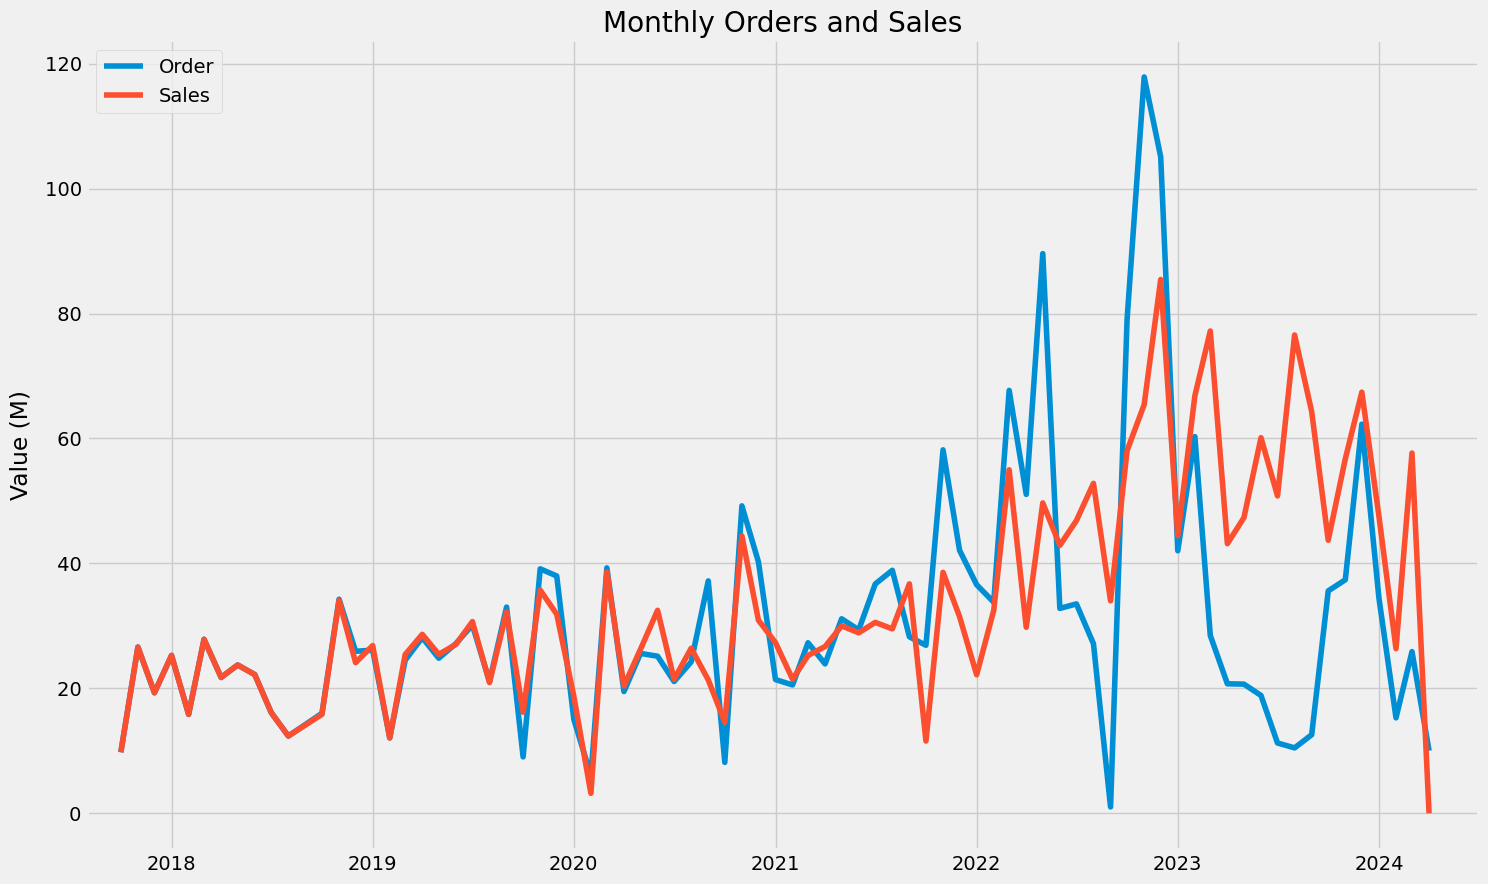

In [2]:
ts = df.groupby('month')[['OR', 'TO']].sum()
fig, ax = plt.subplots(figsize=(16, 10))
x = pd.to_datetime(ts.index)
ax.plot(x, ts['OR'], label='Order')
ax.plot(x, ts['TO'], label='Sales')

# Set the x-axis limits
start, end = pd.Period('2017-07'), pd.Period('2024-06')
ax.set_xlim(start, end)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Create a formatter
million_formatter = FuncFormatter(lambda x, pos: f"{x/1e6: .0f}")
ax.yaxis.set_major_formatter(million_formatter)

ax.set_title('Monthly Orders and Sales')
ax.set_ylabel('Value (M)')
ax.legend(loc='upper left')
plt.show()
fig.savefig('charts/line-chart_Order_Sales.png', bbox_inches='tight', dpi=dpi)

## 新订单、收入订单金额分布
- [Seaborn BoxPlot](https://seaborn.pydata.org/generated/seaborn.boxplot.html)

小额订单占比较多，但存在长尾订单

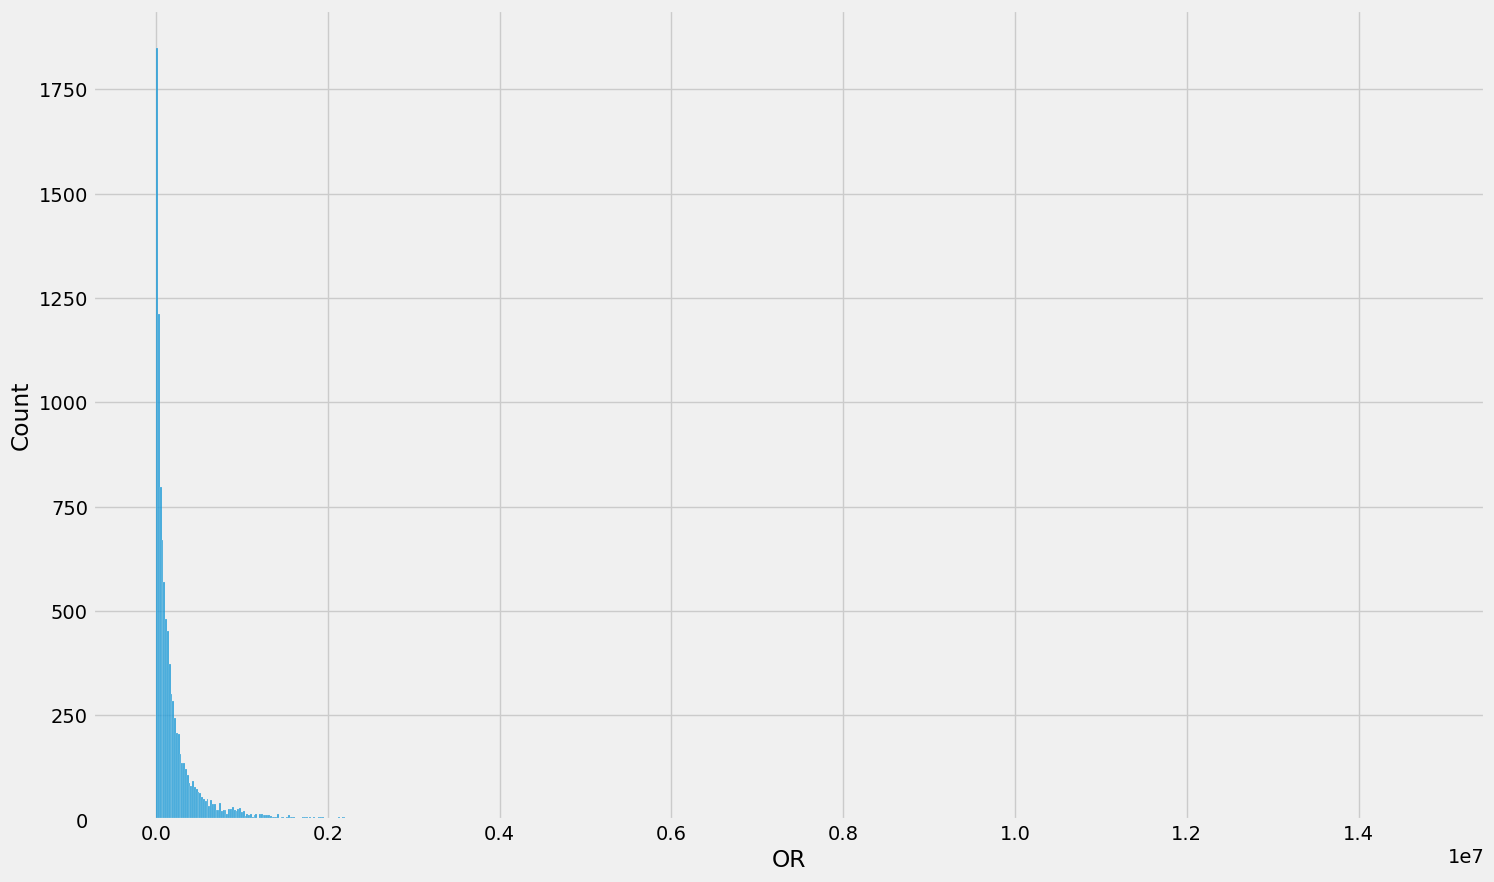

In [3]:
data = df.groupby(['OrderNum'])['OR'].sum()
data = data.loc[data>1]
fig, ax = plt.subplots(figsize=(16, 10))
sns.histplot(data, ax=ax)
# plt.xscale('log')
plt.show()

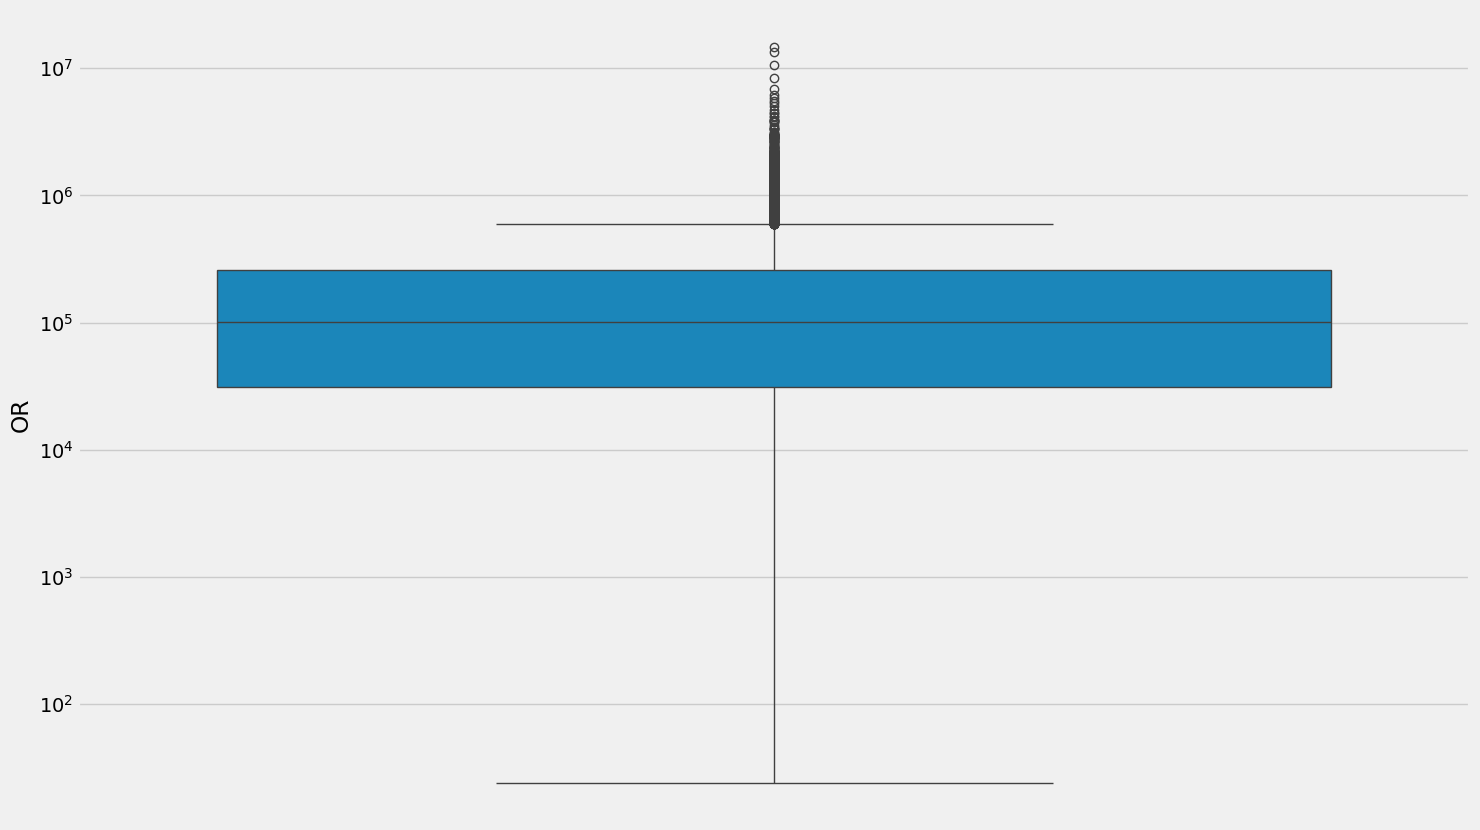

In [4]:
fig, ax = plt.subplots(figsize=(16, 10))
sns.boxplot(data=data, ax=ax)
plt.yscale('log')
plt.show()

### 订单时间序列分解：
1. 订单业务量受经销商（间接业务）的影响较大。
3. 2021年前订单情况呈现稳定增长趋势；由于疫情导致进口不畅，交货期恶化，从21年开始出现恐慌性订单增加。随着货期缓解和库存增加，从22年下半年开始，新订单出现断崖式下降情况。
4. 新订单有很强的季节性规律，例如随着每年的年底为调价期，经销商会因涨价预期而突击订货。每年的9，10月份为财年转换月，经销商会等待新财年任务调整，出现观望情况。
5. 季节性因素（seasonal）及随机因素（residual）影响在最近3年随着经济环境变化震荡加大。

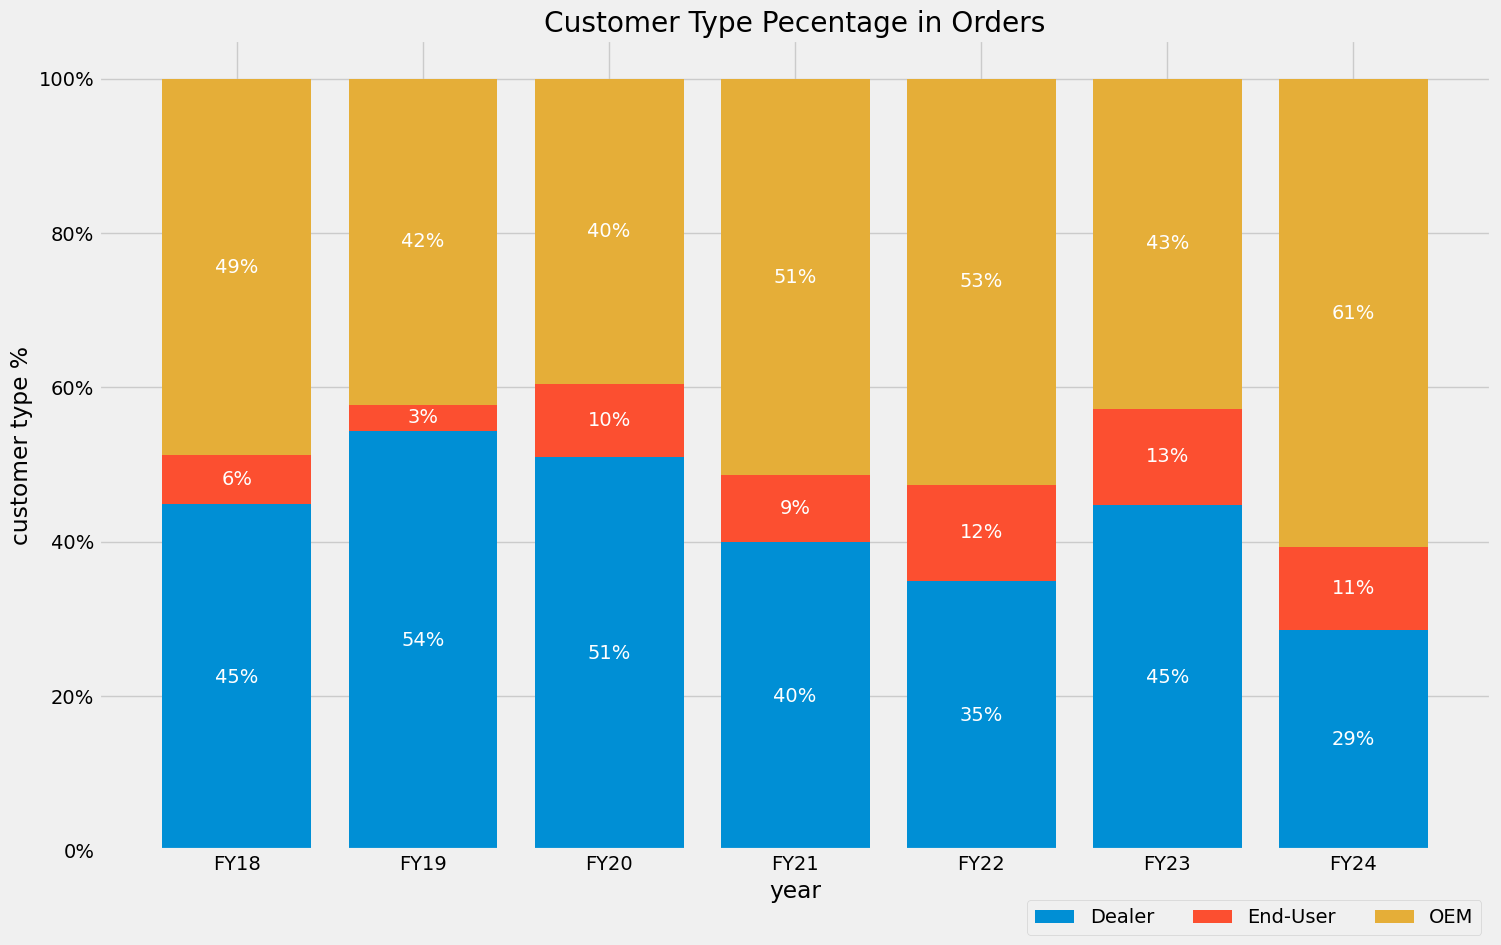

In [5]:
pivot = df.pivot_table(
    index='FiscalYear', columns='BuyerType', 
    values='OR', aggfunc='sum'
) 
pivot = pivot / pivot.sum(axis=1).values.reshape(len(pivot),1)
bottom = pivot.shift(axis=1).fillna(0).cumsum(axis=1)
x = pivot.index

fig, ax = plt.subplots(figsize=(16, 10))

for col in pivot.columns:
    ax.bar(x, pivot[col], bottom=bottom[col], label=col)

# add value labels inside the bars
for i, col in enumerate(pivot.columns):
    for j, val in enumerate(pivot[col]):
        if val > 0:
            ax.text(j, bottom[col].iloc[j] + val / 2, f'{val:.0%}', ha='center', va='center', color='w')

ax.set_xlabel('year')
ax.set_ylabel('customer type %')
ax.set_title('Customer Type Pecentage in Orders')
ax.legend(loc='upper right', bbox_to_anchor=(1.0, -0.05), ncol=len(pivot.columns))

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))

plt.savefig('img/01-Order_by_customer-type.png')
plt.show()
fig.savefig('charts/stack-bar_Order.png', dpi=dpi, bbox_inches='tight', pad_inches=0.5)

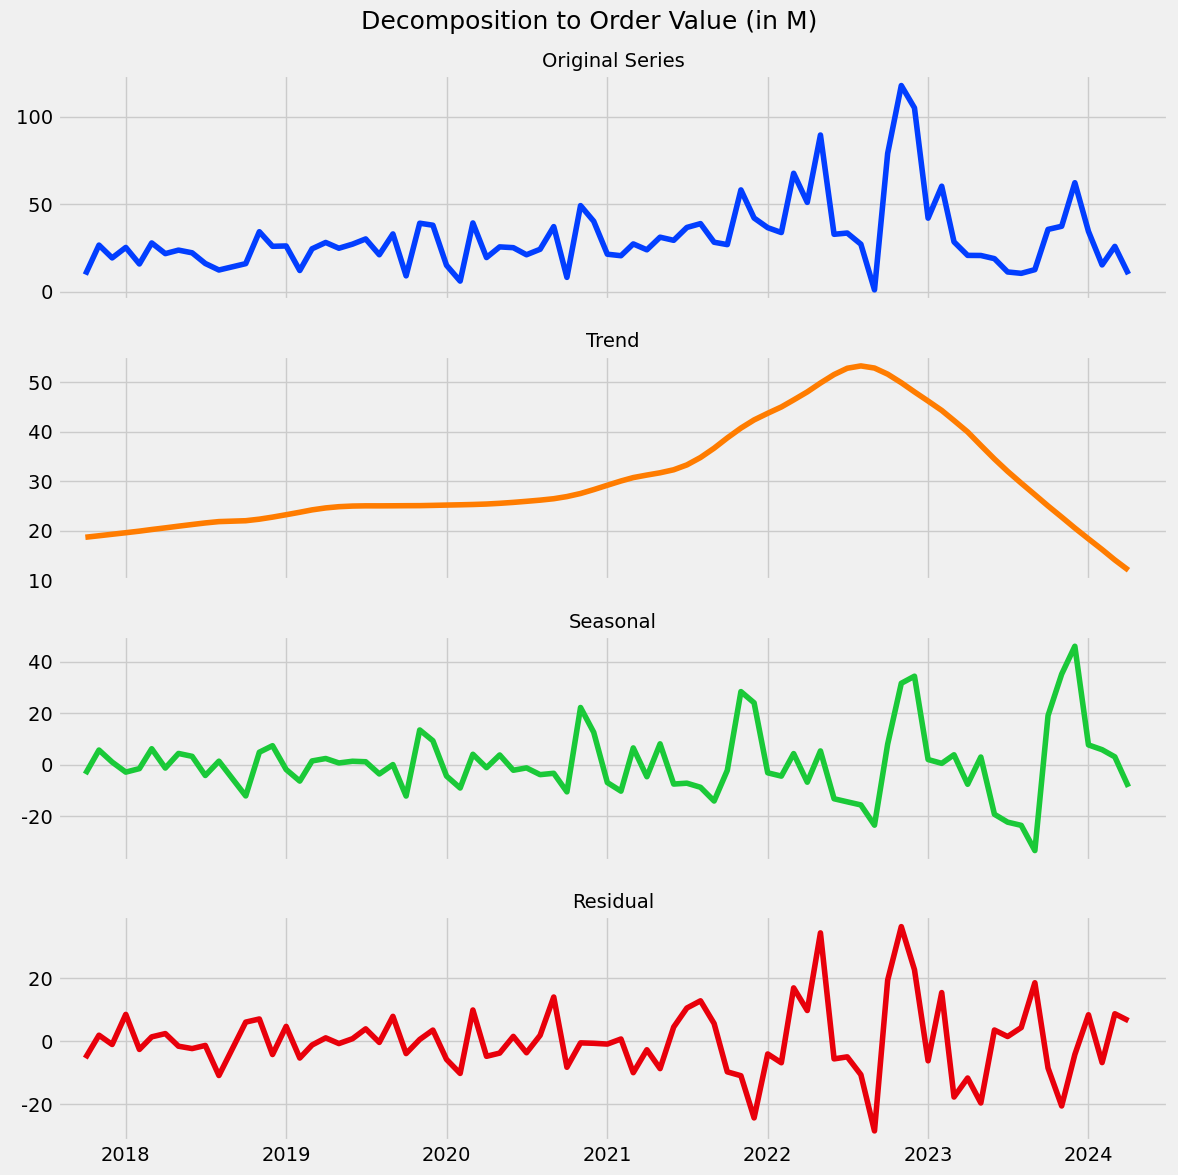

In [6]:
# ts decomposition
from statsmodels.tsa.seasonal import seasonal_decompose, STL
ts = df.groupby('month')['OR'].sum()
decomposition = STL(ts, period=12).fit()

# Plot the decomposed data by matplotlib's subplots
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)
palette = sns.color_palette("bright")
x = pd.to_datetime(ts.index)
y = [decomposition.observed, decomposition.trend, decomposition.seasonal, decomposition.resid]
title = ['Original Series', 'Trend', 'Seasonal', 'Residual']

million_formatter = FuncFormatter(lambda x, pos: f"{x/1e6: .0f}")
for idx in range(4):
    axes[idx].plot(x, y[idx], c=palette[idx])
    axes[idx].set_title(title[idx], size=14)
    axes[idx].yaxis.set_major_formatter(million_formatter)
# Set the x-axis limits
start, end = pd.Period('2017-07'), pd.Period('2024-06')
axes[0].set_xlim(start, end)
axes[0].xaxis.set_major_locator(mdates.YearLocator())
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

fig.suptitle('Decomposition to Order Value (in M)', size=18)
plt.tight_layout()
plt.show()
fig.savefig('charts/decomposition_order', bbox_inches='tight', dpi=dpi, pad_inches=0.5)

### 销售收入时间序列分解：
1. 在销售收入方面，2022年前各客户类型（包括经销商， 最终用户与设备制造商）占比情况与订单情况类似。最近两年，由于经销商在消耗库存和在途订单，收入占比加大，订单占比减少。
2. 收入的趋势与订单趋势类似，但有一定的滞后；
3. 销售收入的季节性不如订单显著；
4. 季节性因素（seasonal）及随机因素（residual）震荡情况销售输入对比新订单要小。

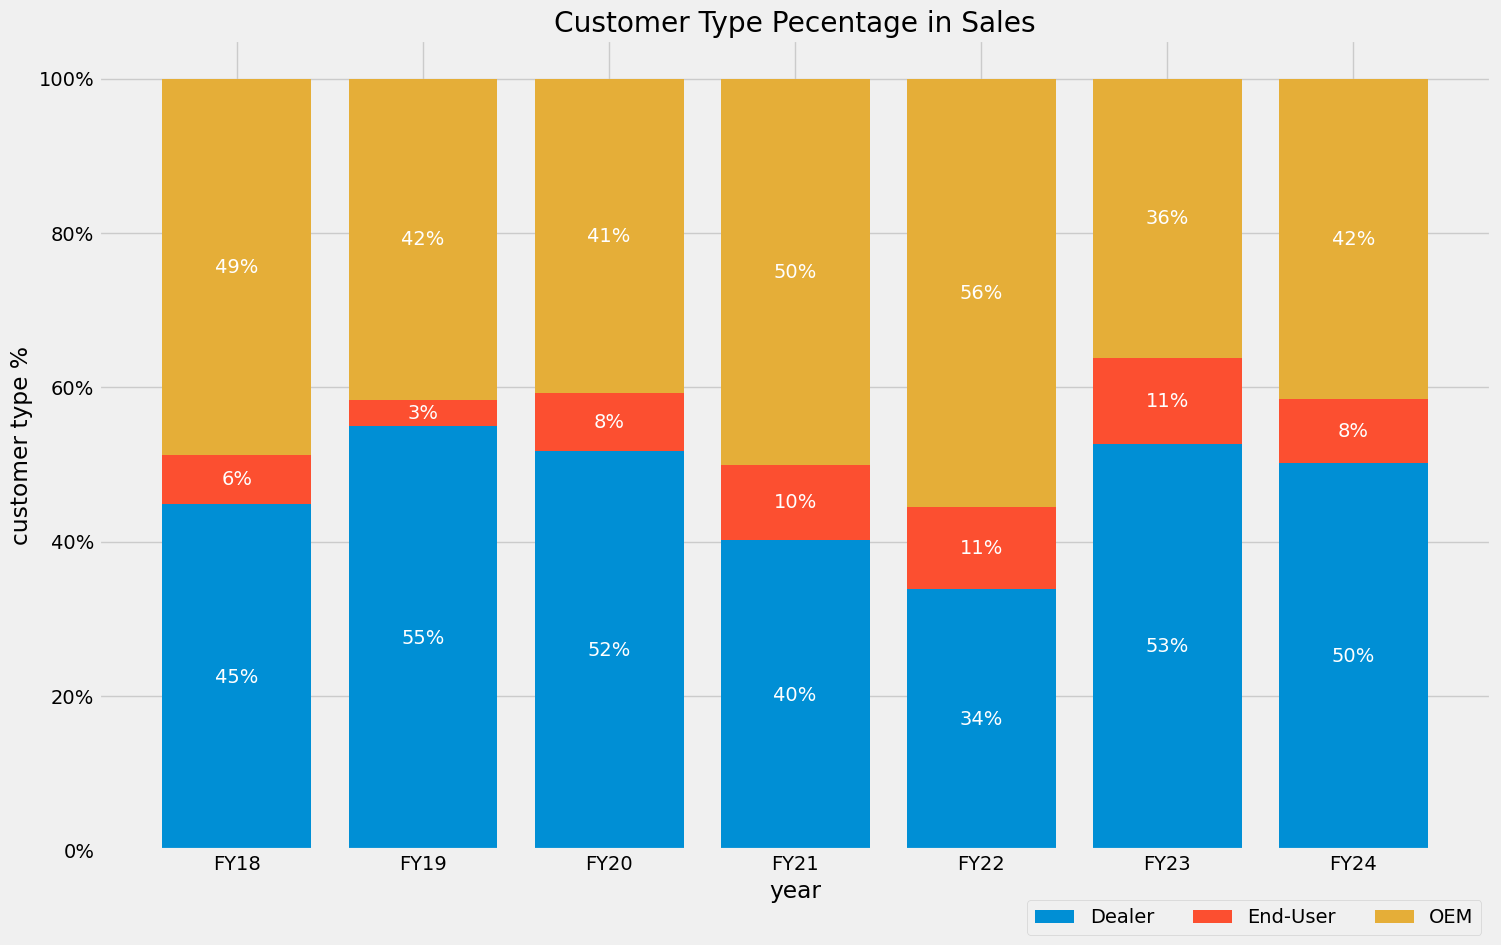

In [7]:
pivot = df.pivot_table(
    index='FiscalYear', columns='BuyerType', 
    values='TO', aggfunc='sum'
) 
pivot = pivot / pivot.sum(axis=1).values.reshape(len(pivot),1)
bottom = pivot.shift(axis=1).fillna(0).cumsum(axis=1)
x = pivot.index

fig, ax = plt.subplots(figsize=(16, 10))

for col in pivot.columns:
    ax.bar(x, pivot[col], bottom=bottom[col], label=col)

# add value labels inside the bars
for i, col in enumerate(pivot.columns):
    for j, val in enumerate(pivot[col]):
        if val > 0:
            ax.text(j, bottom[col].iloc[j] + val / 2, f'{val:.0%}', ha='center', va='center', color='w')

ax.set_xlabel('year')
ax.set_ylabel('customer type %')
ax.set_title('Customer Type Pecentage in Sales')
ax.legend(loc='upper right', bbox_to_anchor=(1.0, -0.05), ncol=len(pivot.columns))

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))

plt.savefig('img/01-Order_by_customer-type.png')
plt.show()
fig.savefig('charts/stack-bar_Order.png', dpi=dpi, bbox_inches='tight', pad_inches=0.5)

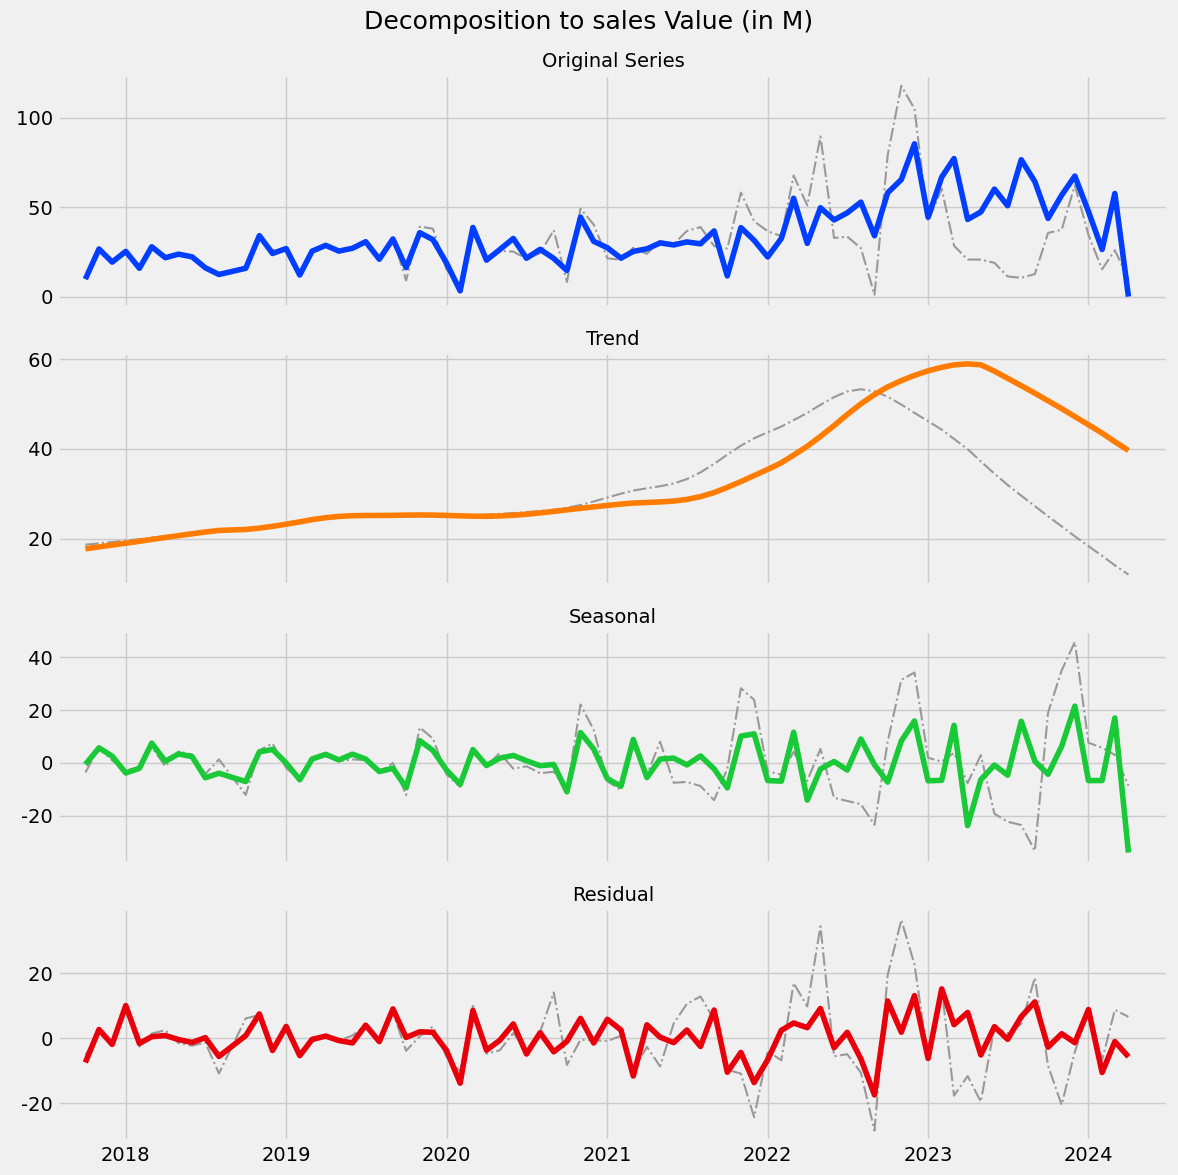

In [8]:
# ts decomposition
from statsmodels.tsa.seasonal import seasonal_decompose, STL
ts = df.groupby('month')['TO'].sum()
decomposition = STL(ts, period=12).fit()

# Plot the decomposed data by matplotlib's subplots
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)
palette = sns.color_palette("bright")
x = pd.to_datetime(ts.index)
y_to = [decomposition.observed, decomposition.trend, decomposition.seasonal, decomposition.resid]
title = ['Original Series', 'Trend', 'Seasonal', 'Residual']

million_formatter = FuncFormatter(lambda x, pos: f"{x/1e6: .0f}")
for idx in range(4):
    axes[idx].plot(x, y[idx], c="#999", lw=1.5, ls='-.')
    axes[idx].plot(x, y_to[idx], c=palette[idx])
    axes[idx].set_title(title[idx], size=14)
    axes[idx].yaxis.set_major_formatter(million_formatter)
    
# Set the x-axis limits
start, end = pd.Period('2017-07'), pd.Period('2024-06')
axes[0].set_xlim(start, end)
axes[0].xaxis.set_major_locator(mdates.YearLocator())
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

fig.suptitle('Decomposition to sales Value (in M)', size=18)
plt.tight_layout()
plt.show()
fig.savefig('charts/decomposition_sales', bbox_inches='tight', dpi=dpi, pad_inches=0.5)

## 客户分布情况

- [Seaborn Histo Plot](https://seaborn.pydata.org/generated/seaborn.histplot.html#seaborn.histplot)

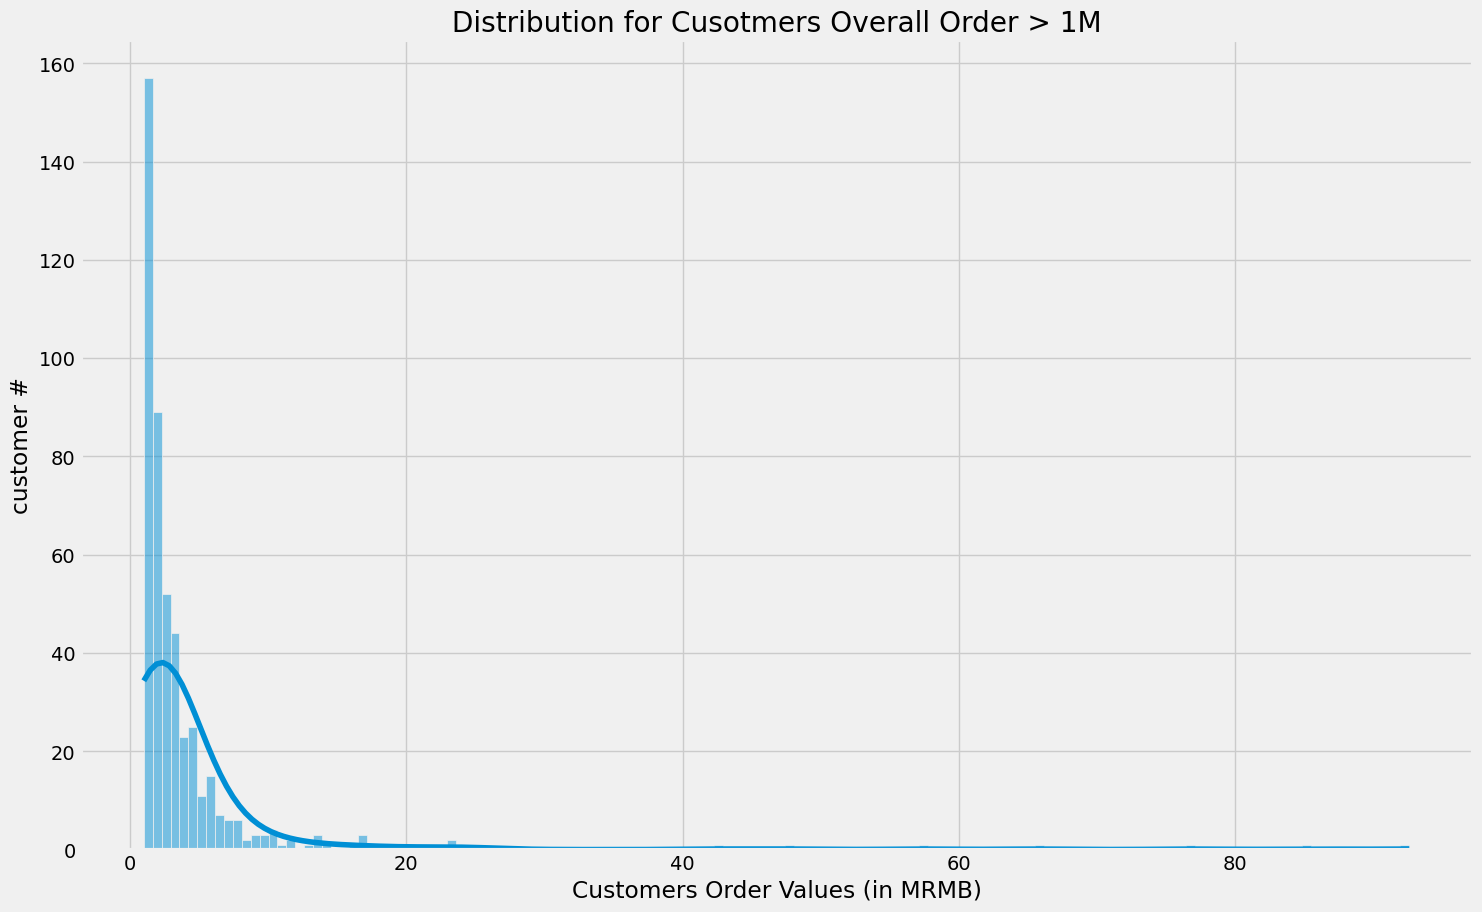

In [9]:
data = df.groupby(['AssignedCustomer'])['OR'].sum()/1e6
data = data.loc[data>1]
fig, ax = plt.subplots(figsize=(16, 10))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sns.histplot(data, ax=ax, kde=True)
    
ax.set_xlabel('Customers Order Values (in MRMB)')
ax.set_ylabel('customer #')
ax.set_title(" Distribution for Cusotmers Overall Order > 1M ")
plt.show()
fig.savefig('charts/histo_customer.png', bbox_inches='tight', dpi=dpi, pad_inches=0.5)

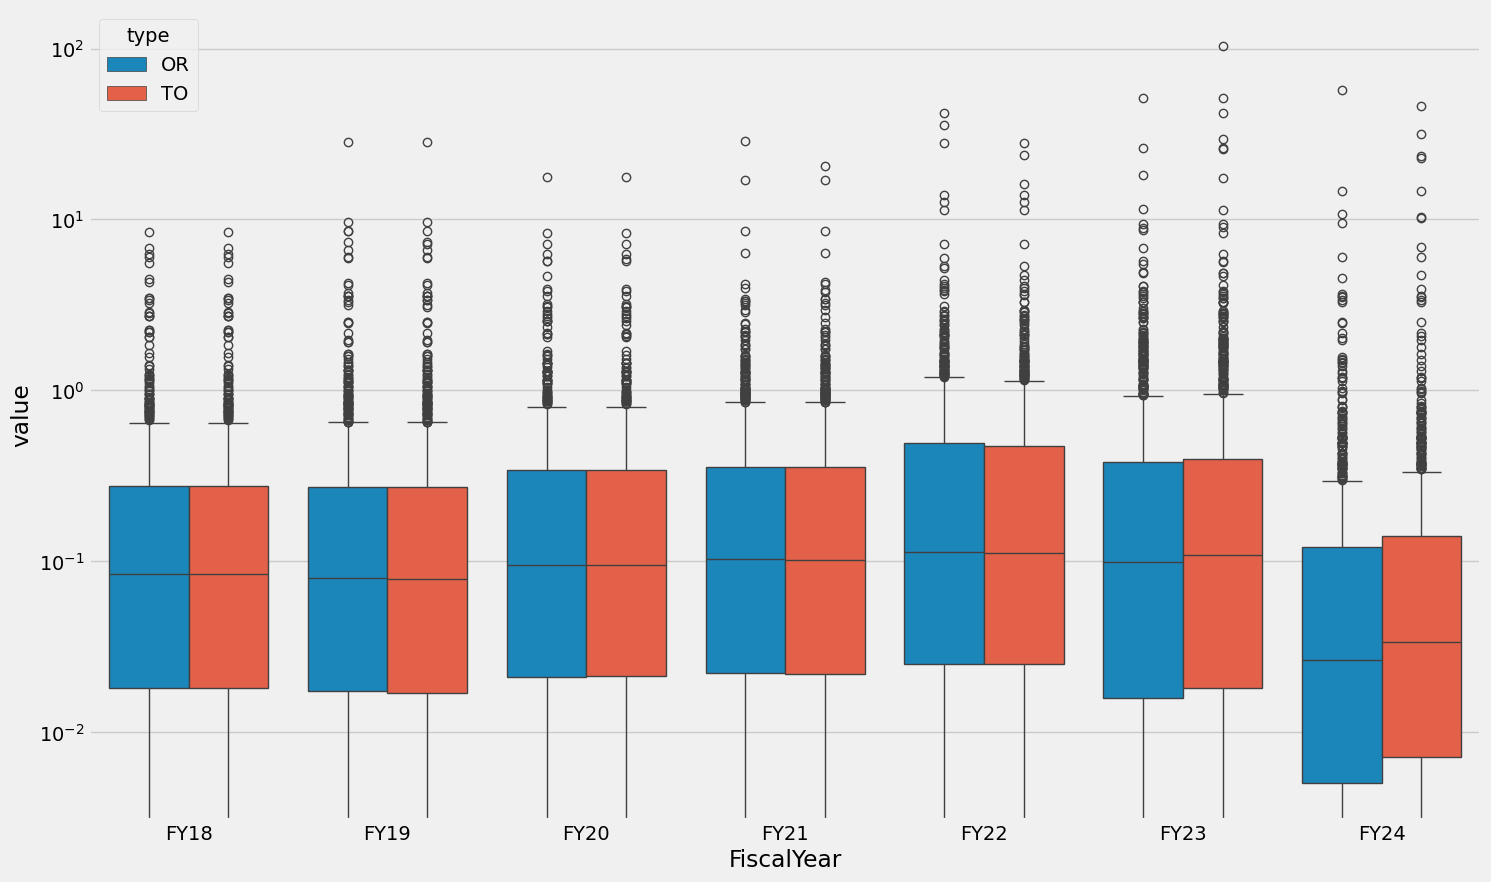

In [10]:
data = df.groupby(['FiscalYear', 'AssignedCustomer'])[['OR', 'TO']].sum()/1e6
data = data.stack().reset_index()
data.columns = ['FiscalYear', 'AssignedCustomer', 'type', 'value']

fig, ax = plt.subplots(figsize=(16, 10))
sns.boxplot(data=data, x='FiscalYear', y='value', hue='type', ax=ax)
plt.yscale('log')
plt.show()
fig.savefig('charts/boxplot_customer.png', bbox_inches='tight', dpi=dpi, pad_inches=0.5)

### 客户销售额帕累托图

本图表主要考察各重点客户(年销售额大于1M)在年度收入中的排序和占比。这里去2023财年的数据，去除间接业务（经销商业务）。

> 帕累托图（Pareto Chart），是一种图表类型，用于突出显示数据集中最重要的因素。它由意大利经济学家维尔弗雷多·帕累托（Vilfredo Pareto）提出。帕累托图常用于质量管理和改善过程中，帮助识别和优先处理最重要的问题。
>
> 帕累托图通常包含以下元素：
> - 条形图：每个条形代表一个类别，条形的高度表示该类别的频次或影响程度。条形按照高度从高到低排序。
> - 折线图：折线图显示累计百分比。它显示每个类别的累积影响，通常用于识别“关键的少数”和“次要的多数”——即20%的原因导致80%的结果（帕累托原则或80/20法则）。

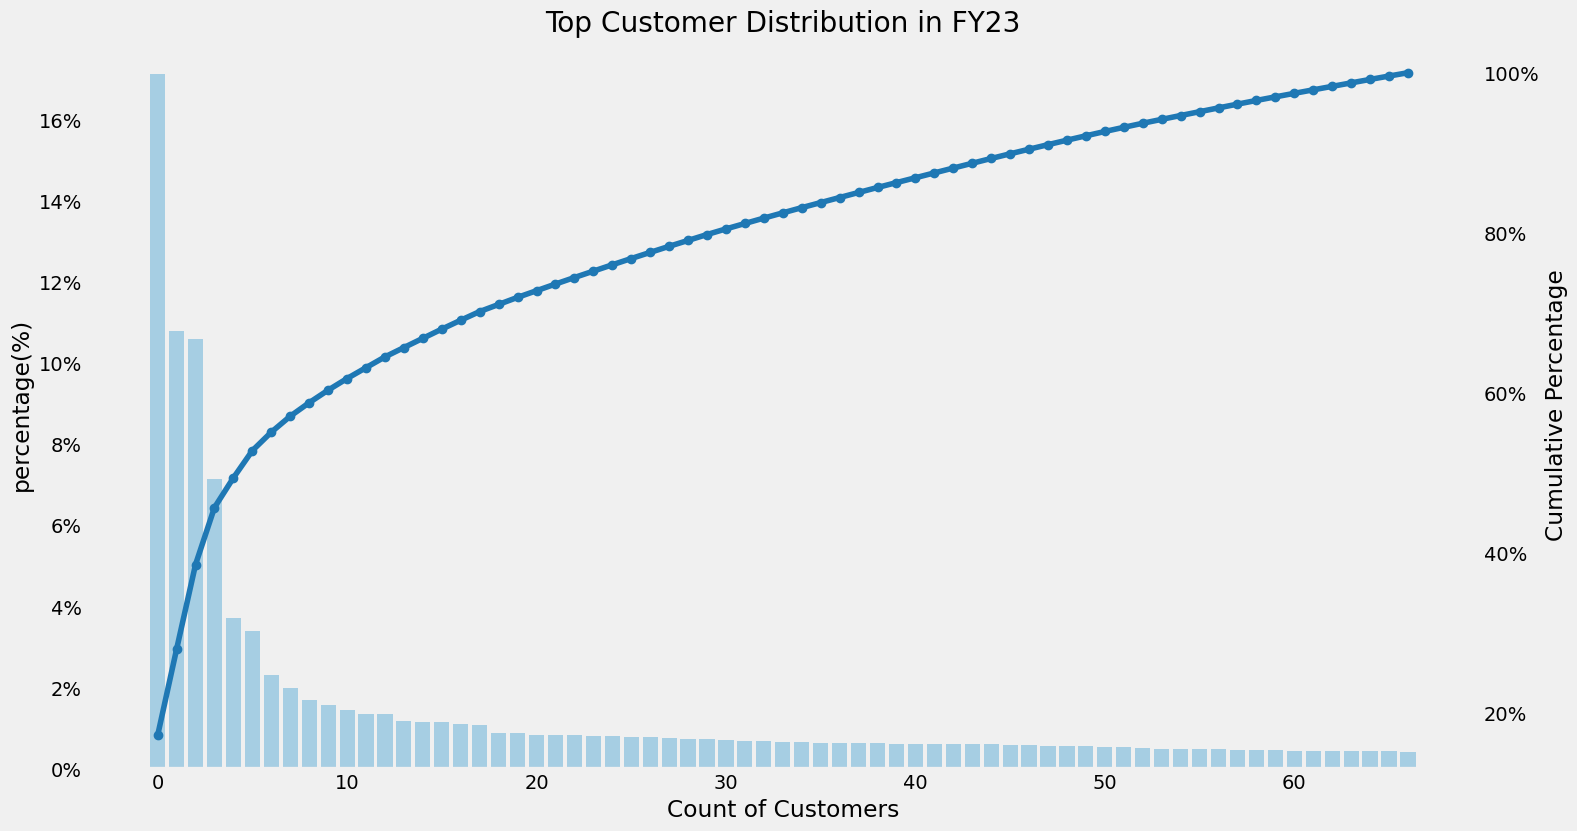

In [11]:
# data uncensored
df = pd.read_csv("data/orders.csv")
pivot = df.loc[
    df.FiscalYear.isin(['FY23'])
    & df.BuyerType.isin(['OEM', 'End-User']) 
].groupby('AssignedCustomer')[['TO']].sum()/1e6
pivot = pivot.loc[pivot.TO > 1]
pivot = pivot.sort_values(ascending=False, by='TO').reset_index()
pivot['percent'] = pivot.TO / pivot.TO.sum()
pivot['cumsum'] = pivot.percent.values.cumsum()

x = pivot.index
y1 = pivot['percent']
y2 = pivot['cumsum']

fig, ax = plt.subplots(figsize=(16, 9))
palette = sns.color_palette("Paired")
ax.bar(x, y1, color=palette[0])
ax2 = ax.twinx()
ax2.plot(x, y2, marker='o', c=palette[1])
# ax2.yaxis.set_major_formatter(PercentFormatter())
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
ax.grid(visible=False)
ax2.grid(visible=False)
ax.set_title("Top Customer Distribution in FY23")
ax.set_xlabel('Count of Customers')
ax.set_ylabel('percentage(%)')
ax2.set_ylabel('Cumulative Percentage')
plt.show()
fig.savefig('charts/customer_pareto_chart.png', bbox_inches='tight', dpi=dpi)